# The (Extended) Kalman Filter
Recall the final system in the Dynamical System section. We reinitialize it here for convenience:

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from pykal.system import System
from numpy.typing import NDArray
from typing import Callable

def driven_SHO_with_params(
      damping_term: float = 0.1,
      stiffness: float = 2.0,
  ) -> Callable:
      def driven_SHO(
          u: NDArray[np.float64],
          x: NDArray[np.float64],
      ) -> NDArray[np.float64]:
          x0, x1 = x[0, 0], x[1, 0]
          u_val = u[0, 0]
          dx0 = x1
          dx1 = -stiffness * x0 - damping_term * x1 + u_val
          return np.array([[dx0], [dx1]], dtype=np.float64)

      return driven_SHO

def u_square_wave_with_params(
    amplitude: float = 10.0,
    period: float = 2.0,
) -> Callable[[float], NDArray[np.float64]]:

    def u_square_wave(t: float) -> NDArray[np.float64]:
        sign = 1.0 if (t % period) < (period / 2) else -1.0
        return np.array([[sign * amplitude]], dtype=np.float64)

    return u_square_wave

def process_noise_with_params(
    noise_in_x0: float = 0.1,
    noise_in_x1: float = 0.1,
) -> Callable[[], NDArray[np.float64]]:

    def Q() -> NDArray[np.float64]:
        return np.diag([noise_in_x0, noise_in_x1]).astype(np.float64)

    return Q

def position_sensor(x: NDArray, u: NDArray, t: float) -> NDArray:
      """Only measure position."""
      return np.array([[x[0, 0]]])  # shape (1, 1)

def measurement_noise_with_params(
    noise_in_x0: float = 0.01,
) -> Callable[[], NDArray[np.float64]]:

    def R() -> NDArray[np.float64]:
        return np.diag([noise_in_x0]).astype(np.float64)

    return R      

sys = System(
f=driven_SHO_with_params(damping_term=0.1,stiffness=2), 
h = position_sensor,
u = u_square_wave_with_params(amplitude=4,period=2),
state_names=["x0", "x1"],
measurement_names=["x0"],
input_names=['force'],
 system_type="cti")

<Axes: title={'center': 'State Trajectories'}, xlabel='Time', ylabel='State Value'>

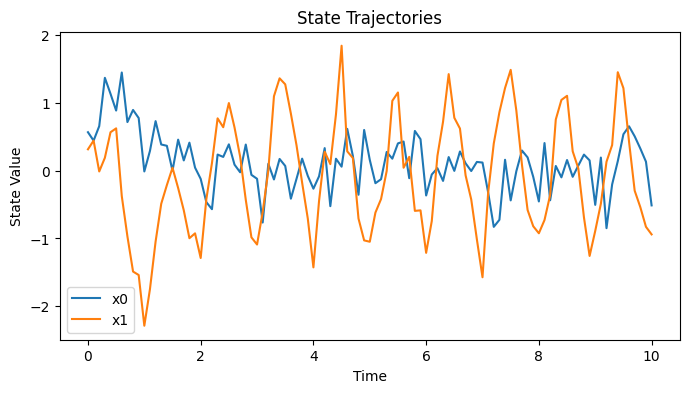

In [2]:
x0 = np.array([[1.0], [0.0]])
X, T = sys.simulate_states(x0=x0, dt=0.1, t_span=(0, 10), 
                           override_system_f=driven_SHO_with_params(damping_term=2,stiffness=3), 
                           override_system_Q=process_noise_with_params(noise_in_x0 = 0.1,noise_in_x1=0.05), 
                           override_system_u=u_square_wave_with_params(amplitude=5,period=1), 
                           override_system_input_names=["force"])
X_df = sys.combine_data_and_time_into_DataFrame(X, T, sys.state_names)
X_df.plot(title="State Trajectories", xlabel="Time", ylabel="State Value", figsize=(8, 4))

<Axes: title={'center': 'True vs Measured x0'}, xlabel='time', ylabel='Value'>

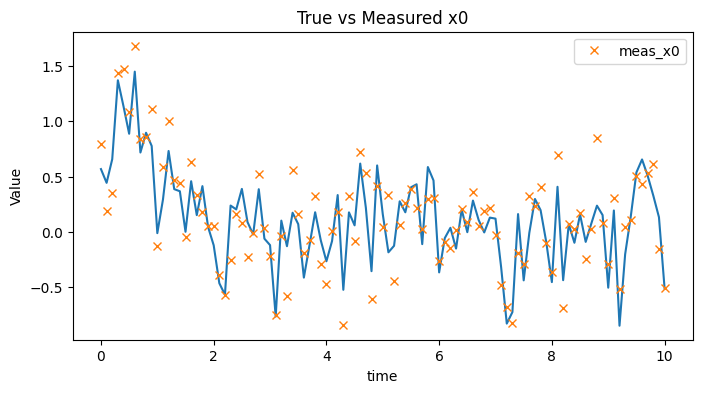

In [7]:
Y, _ = sys.simulate_measurements(X=X, T=T, 
                                 override_system_h = position_sensor,
                                 override_system_R=measurement_noise_with_params(noise_in_x0=0.05),
                                 override_system_measurement_names=["x0"])
Y_df = sys.combine_data_and_time_into_DataFrame(Y,T,["meas_" + name for name in sys.measurement_names])  

ax = X_df["x0"].plot(
      title="True vs Measured x0", xlabel="Time", ylabel="Value", figsize=(8, 4)
  )
Y_df.plot(ax=ax,style="x")

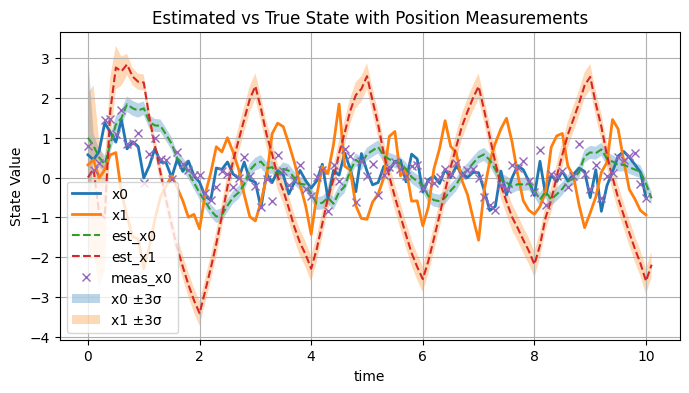

In [16]:
from pykal.kf import EKF
import numpy as np
import matplotlib.pyplot as plt

# Initial guess and covariance
x0_est = np.array([[1], [0.0]])
P0 = 0.5 * np.eye(2)

# Empirical Jacobians using system method
F_emp = sys.compute_empirical_jacobian_wrt_x(sys.f)
H_emp = sys.compute_empirical_jacobian_wrt_x(sys.h)

# Instantiate EKF and run
ekf = EKF(sys)
X_est, P_est, T_est = ekf.run(
    x0=x0_est,
    P0=P0,
    Y=Y,
    start_time=0.0,
    dt=0.1,
    override_system_F=F_emp,
    override_system_H=H_emp,
    square_root=False,
)

# Convert to DataFrame and Series
X_est_df = sys.combine_data_and_time_into_DataFrame(
    X_est, T_est, ["est_" + name for name in sys.state_names]
)
P_est_sr = sys.combine_matrix_series_with_time(P_est, T_est)

# Plot results
ax = X_df.plot(
    title="Estimated vs True State with Position Measurements",
    xlabel="Time",
    ylabel="State Value",
    figsize=(8, 4),
    linewidth=2,
)
X_est_df.plot(ax=ax, linestyle="--")
Y_df.plot(ax=ax, style="x")

# Add ±3σ shaded confidence intervals
for idx, name in enumerate(sys.state_names):
    sigma = P_est_sr.apply(lambda P: np.sqrt(P[idx, idx]))
    est = X_est_df[f"est_{name}"]
    lower = est - 3 * sigma
    upper = est + 3 * sigma
    ax.fill_between(T_est, lower, upper, alpha=0.3, label=f"{name} ±3σ")

ax.legend()
ax.grid(True)

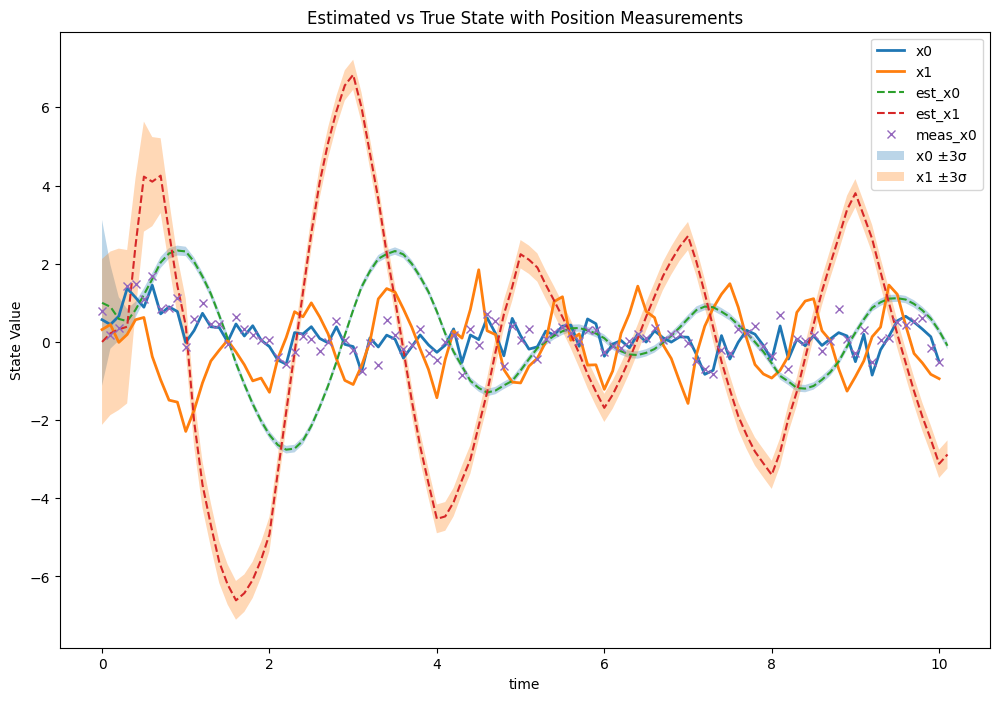

In [20]:
def beta_freeze_x1(t: float) -> NDArray[np.float64]:
    return np.array([[1.0], [0.0]])  # full update for x0, no update for x1

def beta_partial(t: float) -> NDArray[np.float64]:
    return np.array([[0.5], [1.0]])  # partial update for x0, full for x1 

X_est, P_est, T_est = ekf.run(
    x0=x0_est,
    P0=P0,
    Y=Y,
    start_time=0.0,
    dt=0.1,
    override_system_F=F_emp,
    override_system_H=H_emp,
    square_root=False,
    override_system_beta = beta_partial
)
# Convert to DataFrame and Series
X_est_df = sys.combine_data_and_time_into_DataFrame(
    X_est, T_est, ["est_" + name for name in sys.state_names]
)
P_est_sr = sys.combine_matrix_series_with_time(P_est, T_est)

# Plot results
ax = X_df.plot(
    title="Estimated vs True State with Position Measurements",
    xlabel="Time",
    ylabel="State Value",
    figsize=(12, 8),
    linewidth=2,
)
X_est_df.plot(ax=ax, linestyle="--")
Y_df.plot(ax=ax, style="x")

# Add ±3σ shaded confidence intervals
for idx, name in enumerate(sys.state_names):
    sigma = P_est_sr.apply(lambda P: np.sqrt(P[idx, idx]))
    est = X_est_df[f"est_{name}"]
    lower = est - 3 * sigma
    upper = est + 3 * sigma
    ax.fill_between(T_est, lower, upper, alpha=0.3, label=f"{name} ±3σ")

ax.legend()